https://www.kaggle.com/deffro/eda-is-fun

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train_V2.csv', 'test_V2.csv', 'sample_submission_V2.csv']


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv('../input/train_V2.csv')
train.shape

(4446966, 29)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


- groupId : identify a group within a match. 만약 같은 사람들로 이루어진 팀이 다른 매치에 참가했다면, 다른 그룹아이디가 주어짐
- matchId : identify match. train data와 test data에 겹치는 아이디 없음
- assists : 팀원이 죽인 플레이어에 데미지 입힌 횟수
- boosts : number of boost items used
- damageDealt : total damage dealt. 셀프 데미지는 빼고
- DBNOs : number of enemy players knocked
- headshotKills : Number of enemy players killed with headshots.
- heals : Number of healing items used.
- killPlace : 많이 죽인 플레이어 랭킹
- killPoints : Kills-based external ranking of player
- kills : number of enemy players killed
- killStreaks : Max number of enemy players killed in a short amount of time.
- longestKill : Longest distance between player and player killed at time of death. This may be misleading, as downing a : player and driving away may lead to a large longestKill stat.
- maxPlace : Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- numGroups : Number of groups we have data for in the match.
- revives : Number of times this player revived teammates.
- rideDistance : Total distance traveled in vehicles measured in meters.
- roadKills : Number of kills while in a vehicle.
- swimDistance : Total distance traveled by swimming measured in meters.
- teamKills : Number of times this player killed a teammate.
- vehicleDestroys : Number of vehicles destroyed.
- walkDistance : Total distance traveled on foot measured in meters.
- weaponsAcquired : Number of weapons picked up.
- winPoints : Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.)
- winPlacePerc : The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [6]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


# winPlacePerc(target)

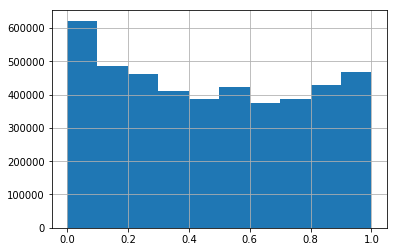

In [28]:
#1 - 1등 / 0 -꼴등
#maxPlce를 기준으로 계산됨. 따라서 중간에 나간 그룹들 포함
train.winPlacePerc.hist()

# the killers

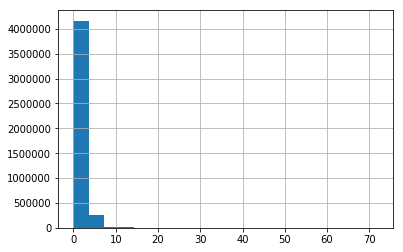

In [10]:
train['kills'].hist(bins = 20)

In [11]:
print('The average person kills {:4f} playesrs, 99% of people have {} kills or less, while the most kills ever recorded is {}'.format(train['kills'].mean(), 
                                                                                                                                      train['kills'].quantile(0.99), train['kills'].max()))

The average person kills 0.924783 playesrs, 99% of people have 7.0 kills or less, while the most kills ever recorded is 72


In [15]:
train[['kills']].describe()

,kills
count,4.446966e+06
mean,9.247833e-01
std,1.558445e+00
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,1.000000e+00
max,7.200000e+01


In [25]:
train['kills'].quantile([0.50,0.75,0.8,0.99])

0.50    0.0
0.75    1.0
0.80    2.0
0.99    7.0
Name: kills, dtype: float64

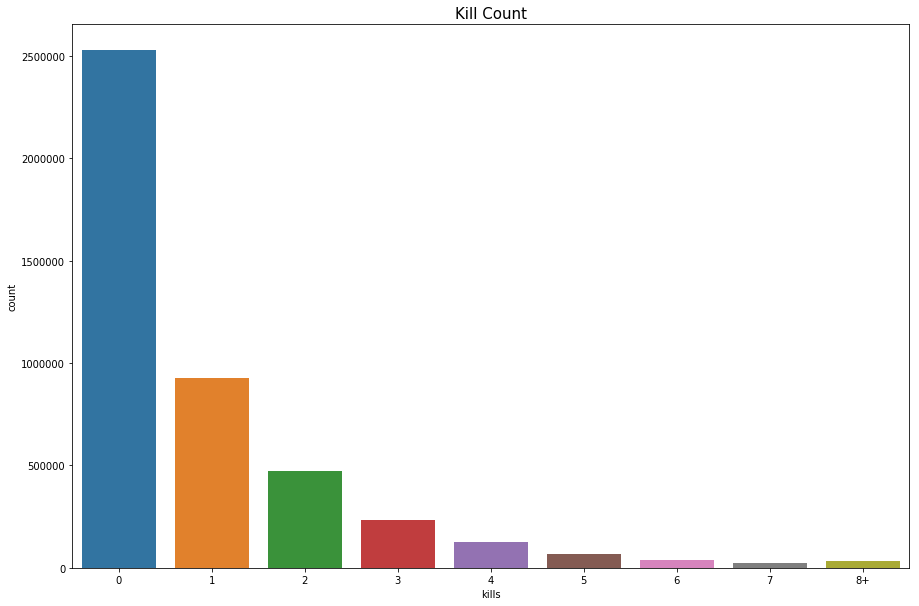

In [17]:
data = train.copy()
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+' #7보다 큰 값들은 1%미만이므로 다 한번에 8+로 통일
plt.figure(figsize = (15,10))

sns.countplot(data['kills'].astype('str').sort_values())
plt.title('Kill Count', fontsize = 15)
plt.show()

대부분의 사람이 1킬도 못 함... 그렇다면 데미지는 어떨까??

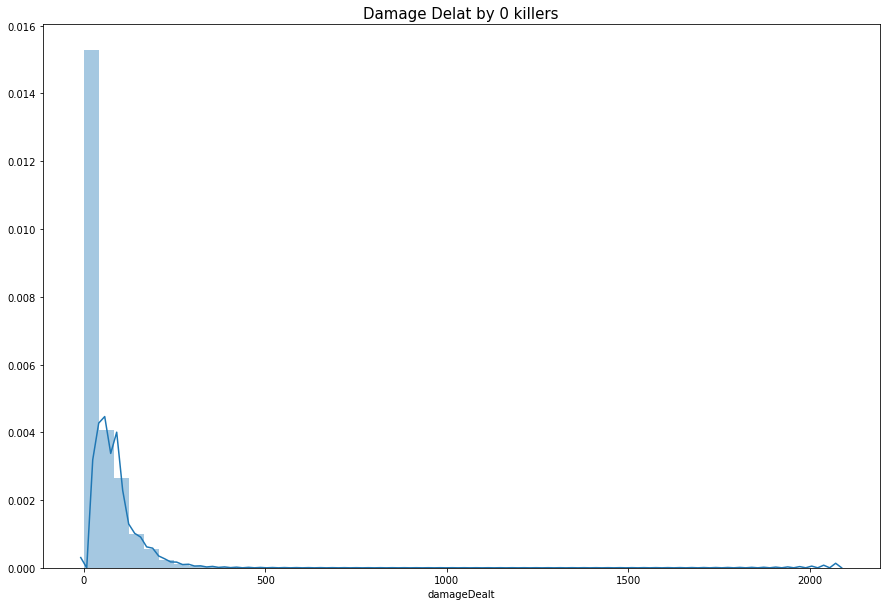

In [26]:
data = train.copy()
data = data[data['kills'] == 0] #0kill인 경우만 고려

plt.figure(figsize = (15,10))
plt.title('Damage Delat by 0 killers', fontsize = 15)
sns.distplot(data['damageDealt'])
plt.show()

0kill을 올린 대부분의 사람들이 데미지도 거의 못 끼친다. 그렇다면, 예외인 사람들을 살펴보자!

In [29]:
print('{} players ({:.4f}%) 1 kill도 안 하고 우승함!'.format(len(data[data['winPlacePerc'] == 1]), 100*len(data[data['winPlacePerc'] == 1])/len(train)))

data1 = train[train['damageDealt'] == 0].copy() #데미지 딜량0인 경우
print(' {} players ({:.4f}%) 데미지 하나도 못 끼치고 우승함!'.format(len(data1[data1['winPlacePerc']==1]), 100*len(data1[data1['winPlacePerc']==1]) / len(train)))

16666 players (0.3748%) 1 kill도 안 하고 우승함!
 4770 players (0.1073%) 데미지 하나도 못 끼치고 우승함!


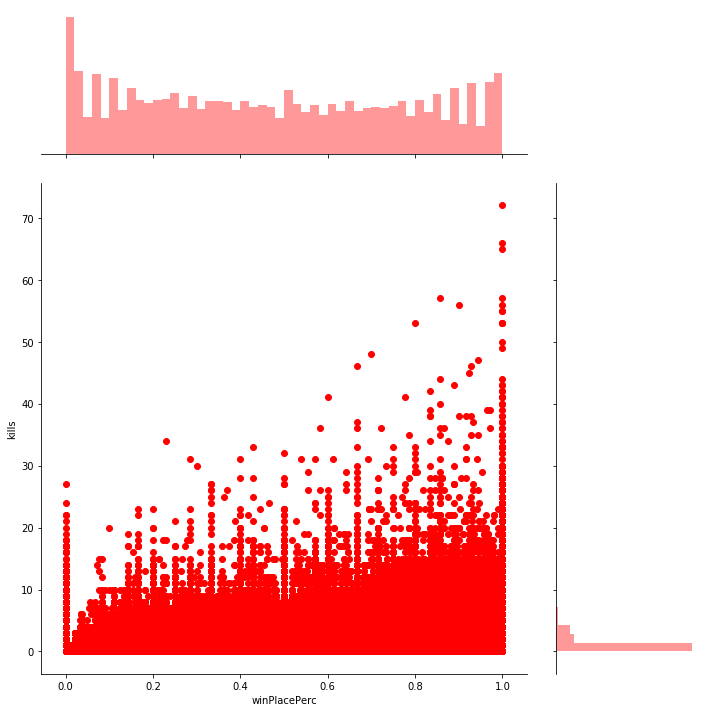

In [30]:
sns.jointplot(x = 'winPlacePerc', y = 'kills', data = train, height = 10, ratio = 3, color = 'r')
#height : size of the figure
#ratio : ratio of joint axes height to marginal axes height
plt.show()

분명히 kill과 winning과 상관관계가 있다. 플레이어들을 kill수를 기반으로 묶어보자

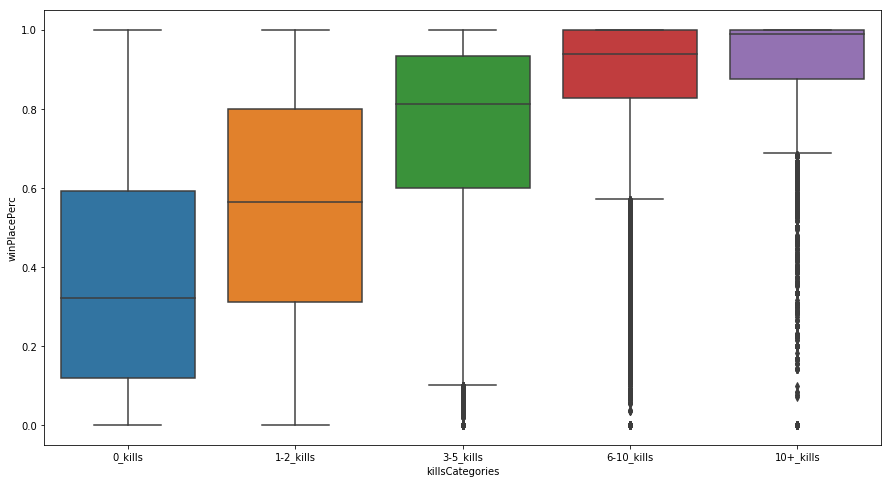

In [32]:
kills = train.copy()

kills['killsCategories'] = pd.cut(kills['kills'], [-1,0,2,5,10,72], labels = ['0_kills','1-2_kills','3-5_kills','6-10_kills','10+_kills'])
#pd.cut (-1,0](0,2](2,5](5,10](10,72]
plt.figure(figsize = (15,8))
sns.boxplot(x = 'killsCategories', y = 'winPlacePerc', data = kills)
plt.show()

# the runners

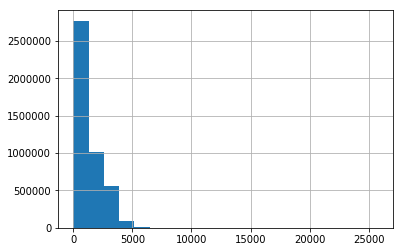

In [35]:
train['walkDistance'].hist(bins = 20)

In [33]:
print('평균적으로 한 사람당 {:.1f}m 걷고, 99%의 사람들은 {}m 이하로 걷는다. 가장 많이 걷는 사람은 {}m'.format(train['walkDistance'].mean(), train['walkDistance'].quantile(0.99),
                                                                              train['walkDistance'].max()))

평균적으로 한 사람당 1154.2m 걷고, 99%의 사람들은 4396.0m 이하로 걷는다. 가장 많이 걷는 사람은 25780.0m


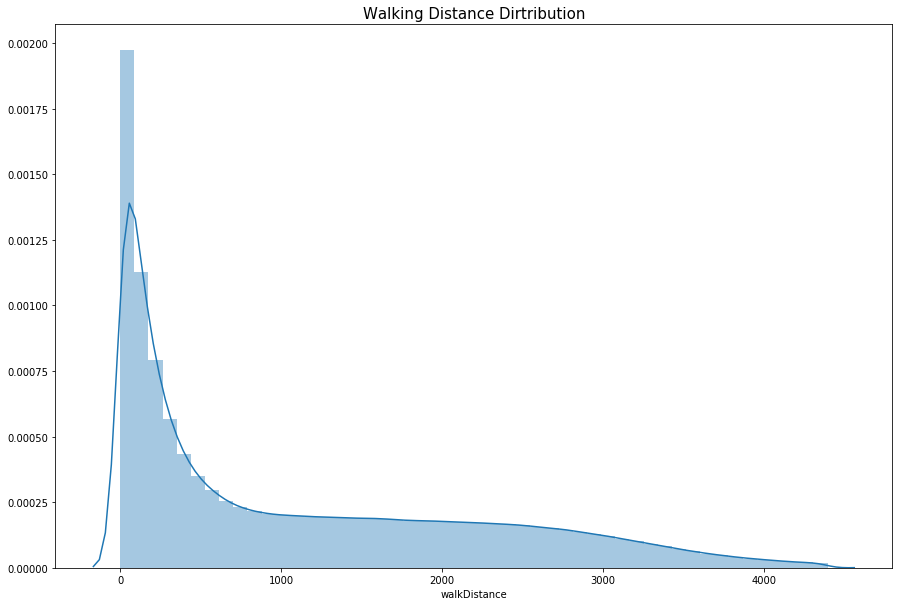

In [42]:
data = train.copy()
data = data[data['walkDistance'] < train['walkDistance'].quantile(0.99)]
#1%의 아웃라이어 빼고 대부분의 사람들만 보자
plt.figure(figsize = (15,10))
plt.title('Walking Distance Dirtribution', fontsize = 15)
sns.distplot(data['walkDistance'])
plt.show()

In [47]:
print('{} players ({:.4f}%) 0미터를 걷는다. 한 걸음도 못 걷고 죽는다. 또는 afk(away from keyboard))'.format(len(data[data['walkDistance'] == 0]),
                                                                                        100*len(data1[data1['walkDistance']==0])/len(train)))

99603 players (2.0329%) 0미터를 걷는다. 한 걸음도 못 걷고 죽는다. 또는 afk(away from keyboard))


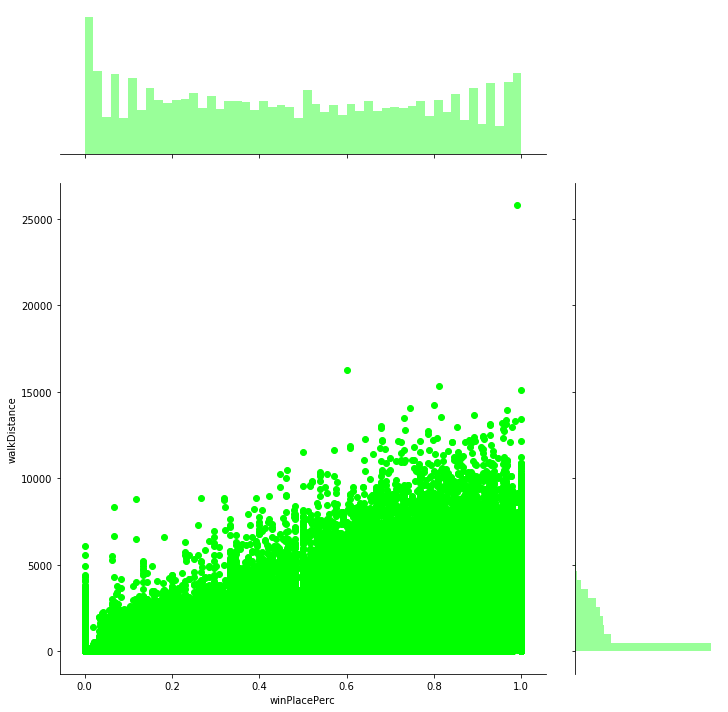

In [48]:
sns.jointplot( x = 'winPlacePerc', y = 'walkDistance', data = train, height = 10, ratio = 3, color= 'lime')

오래 걸을수록 등수가 올라간다. 단순하게 생각하면, 끝까지 살아남아야 하는 게임이니까

# the drivers

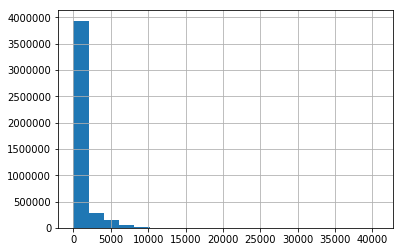

In [49]:
train['rideDistance'].hist(bins = 20)

In [50]:
print('평균적으로 {:.1f}m 를 운전하고, 99% 사람이 {}m 이하로 운전한다. 제일 많이 운전한 사람은 {}m 운전한다.'.format(train['rideDistance'].mean(),
                                                                                  train['rideDistance'].quantile(0.99), train['rideDistance'].max()))

평균적으로 606.1m 를 운전하고, 99% 사람이 6966.0m 이하로 운전한다. 제일 많이 운전한 사람은 40710.0m 운전한다.


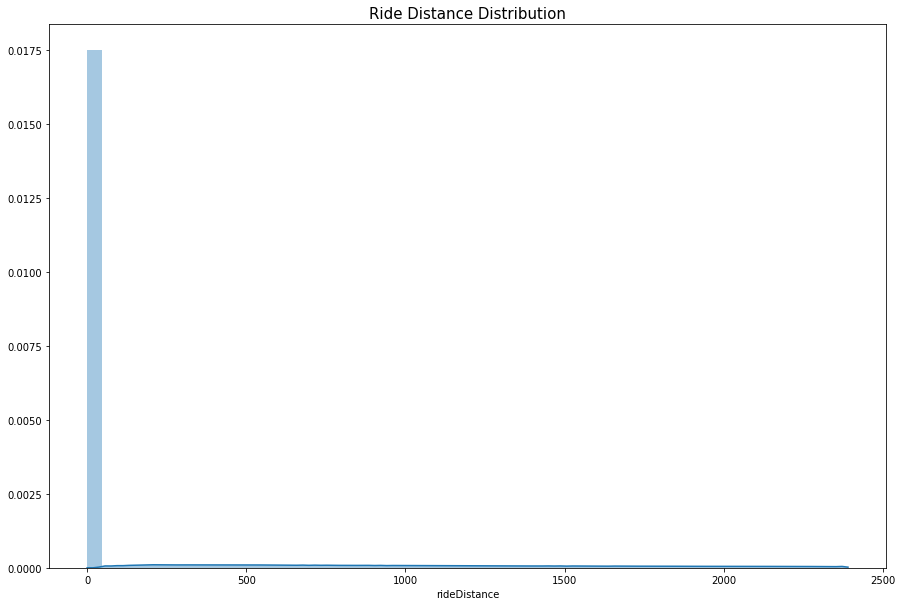

In [57]:
data = train.copy()
data = data[data['rideDistance'] < train['rideDistance'].quantile(0.9)]
plt.figure(figsize = (15,10))
plt.title('Ride Distance Distribution', fontsize = 15)
sns.distplot(data['rideDistance'])
plt.show()

In [58]:
print('{} plyaers ({:.4f}%) drived for 0meters. '.format(len(data[data['rideDistance'] == 0]), 100*len(data1[data1['rideDistance']==0])/len(train)))

3309429 plyaers (23.1022%) drived for 0meters. 


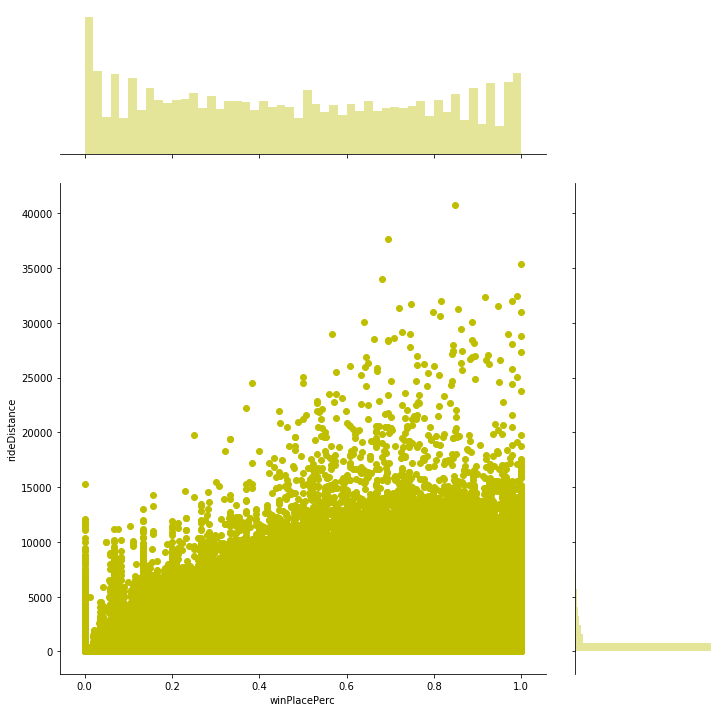

In [59]:
sns.jointplot(x = 'winPlacePerc', y = 'rideDistance', data = train, height = 10, ratio = 3, color =  'y')
plt.show()

rideDistance와 약간의 상관관계를 보인다

가설 : 경험적으로 탈 것을 파괴하는 건 플레이어의 스킬을 보여준다

In [60]:
train['vehicleDestroys'].value_counts()

0    4413212
1      32422
2       1223
3         95
4         11
5          3
Name: vehicleDestroys, dtype: int64

In [61]:
data['vehicleDestroys'].value_counts()

0    3984401
1      17341
2        483
3         34
4          4
Name: vehicleDestroys, dtype: int64

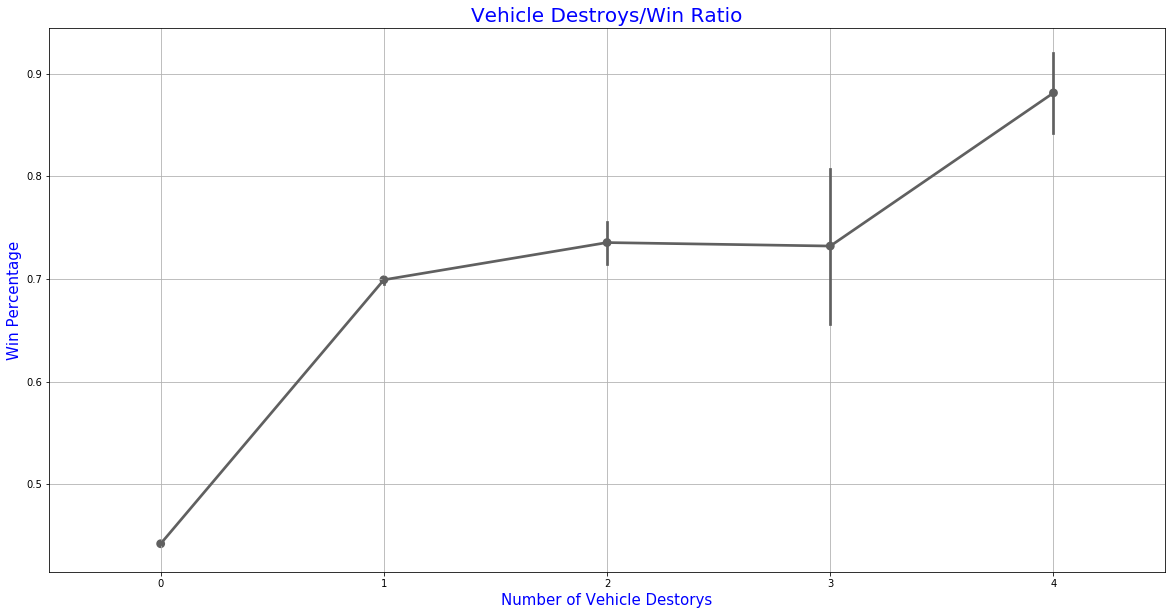

In [65]:
fx, ax = plt.subplots(figsize = (20,10))
#seaborn pointplot이 보여주는 건 평균과 CI
sns.pointplot(x = 'vehicleDestroys', y = 'winPlacePerc', data = data, color = '#606060', alpha = 0.8)

plt.xlabel('Number of Vehicle Destorys', fontsize = 15, color = 'blue')
plt.ylabel('Win Percentage', fontsize = 15, color = 'blue')
plt.title('Vehicle Destroys/Win Ratio', fontsize = 20, color = 'blue')
plt.grid()
plt.show()

나의 가설이 맞았다! 탈 것을 많이 부수면, 우승 기회가 증가한다

# the swimmers

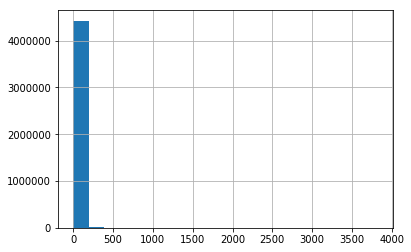

In [68]:
train['swimDistance'].hist(bins = 20)

In [69]:
print('평균적으로 {:.1f}m 를 수영하고, 99% 사람이 {}m 이하로 수영한다. 제일 많이 수영한 사람은 {}m 수영한다.'.format(train['swimDistance'].mean(),
                                                                                  train['swimDistance'].quantile(0.99), train['swimDistance'].max()))

평균적으로 4.5m 를 수영하고, 99% 사람이 123.0m 이하로 수영한다. 제일 많이 수영한 사람은 3823.0m 수영한다.


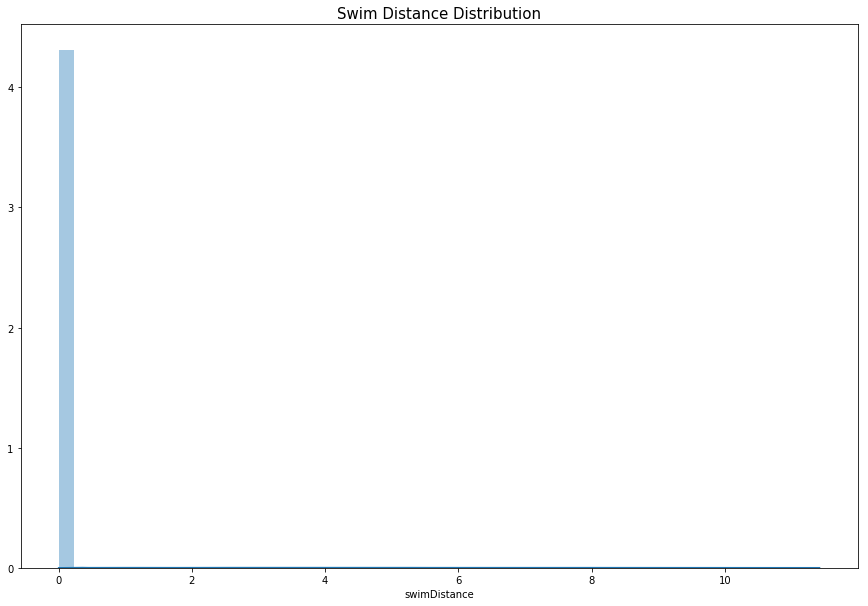

In [70]:
data = train.copy()
data = data[data['swimDistance'] < train['swimDistance'].quantile(0.95)]
plt.figure(figsize = (15,10))
plt.title('Swim Distance Distribution', fontsize = 15)
sns.distplot(data['swimDistance'])
plt.show()

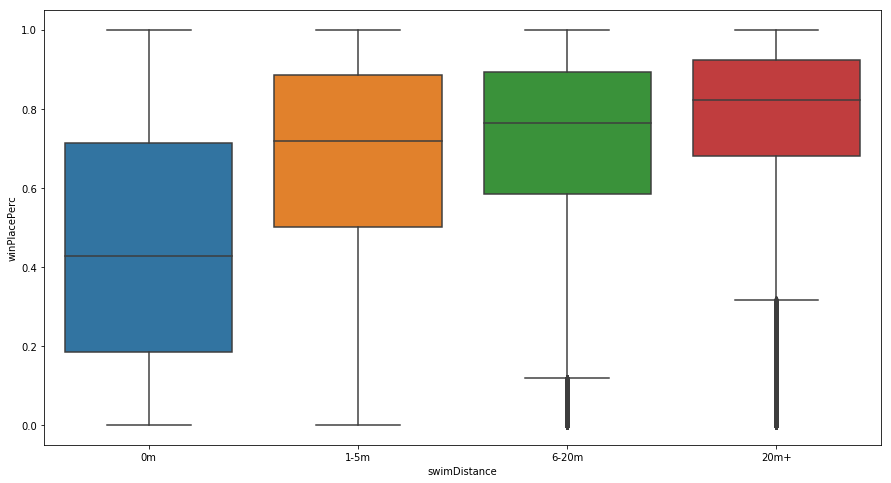

In [71]:
swim = train.copy()
swim['swimDistance'] = pd.cut(swim['swimDistance'], [-1,0,5,20,3823], labels = ['0m', '1-5m','6-20m','20m+'])

plt.figure(figsize = (15,8))
sns.boxplot(x = 'swimDistance', y = 'winPlacePerc', data = swim)
plt.show()

오 수영오래하면 살 확률이 높아지는 것 같다! 근데 PUBG 맵에 따라 물이 거의 없는 맵도 있으니까 조심해야됨

# The Healers

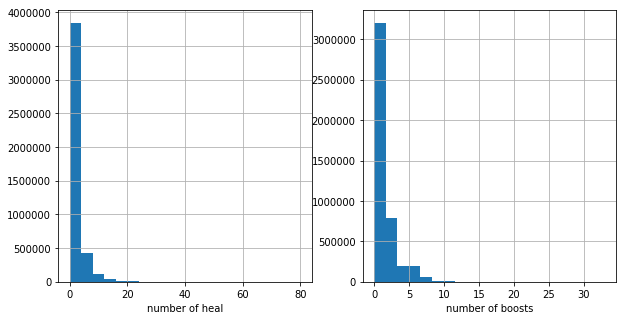

In [85]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
train.heals.hist(bins = 20)
plt.xlabel('number of heal')

plt.subplot(1,2,2)
train.boosts.hist(bins = 20)
plt.xlabel('number of boosts')

plt.show()

In [86]:
print('평균적으로 {:.1f}번 힐하고, 99% 사람이 {}번 이하로 힐한다. 제일 많이 힐한 사람은 {}번.'.format(train['heals'].mean(),
                                                                                  train['heals'].quantile(0.99), train['heals'].max()))
print('평균적으로 {:.1f}번 boosting하고, 99% 사람이 {}번 이하로 boosting한다. 제일 많이 boosting한 사람은 {}번.'.format(train['boosts'].mean(),
                                                                                  train['boosts'].quantile(0.99), train['boosts'].max()))

평균적으로 1.4번 힐하고, 99% 사람이 12.0번 이하로 힐한다. 제일 많이 힐한 사람은 80번.
평균적으로 1.1번 boosting하고, 99% 사람이 7.0번 이하로 boosting한다. 제일 많이 boosting한 사람은 33번.


In [88]:
data = train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

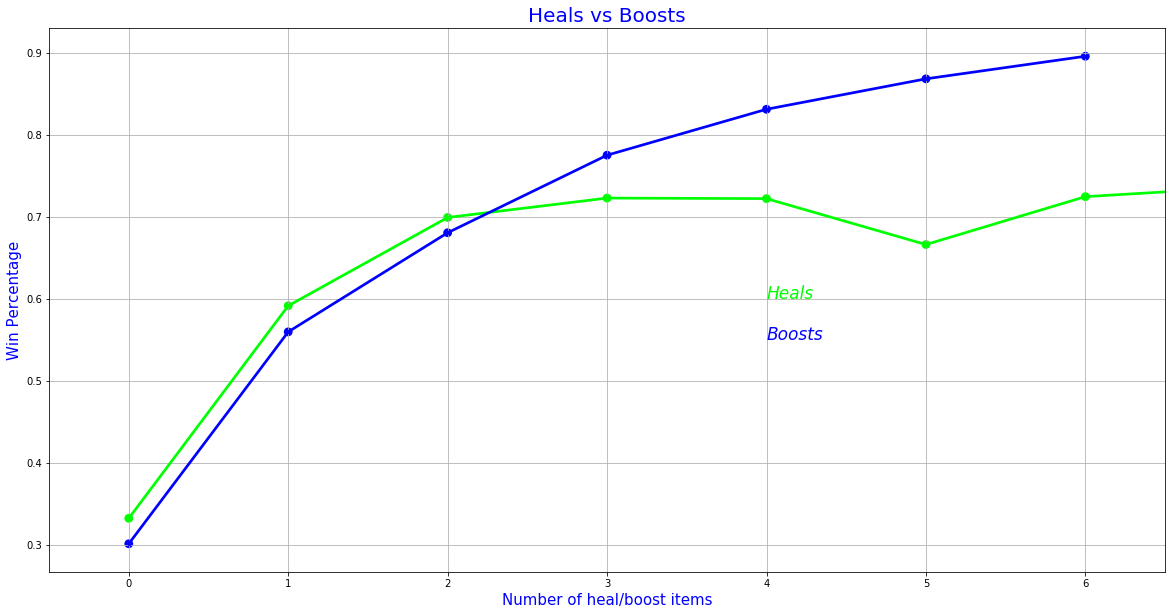

In [89]:
f,ax = plt.subplots(figsize =(20,10))
sns.pointplot(x='heals',y='winPlacePerc',data=data,color='lime',alpha=0.8)
sns.pointplot(x='boosts',y='winPlacePerc',data=data,color='blue',alpha=0.8)
plt.text(4,0.6,'Heals',color='lime',fontsize = 17,style = 'italic')
plt.text(4,0.55,'Boosts',color='blue',fontsize = 17,style = 'italic')
plt.xlabel('Number of heal/boost items',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Heals vs Boosts',fontsize = 20,color='blue')
plt.grid()
plt.show()

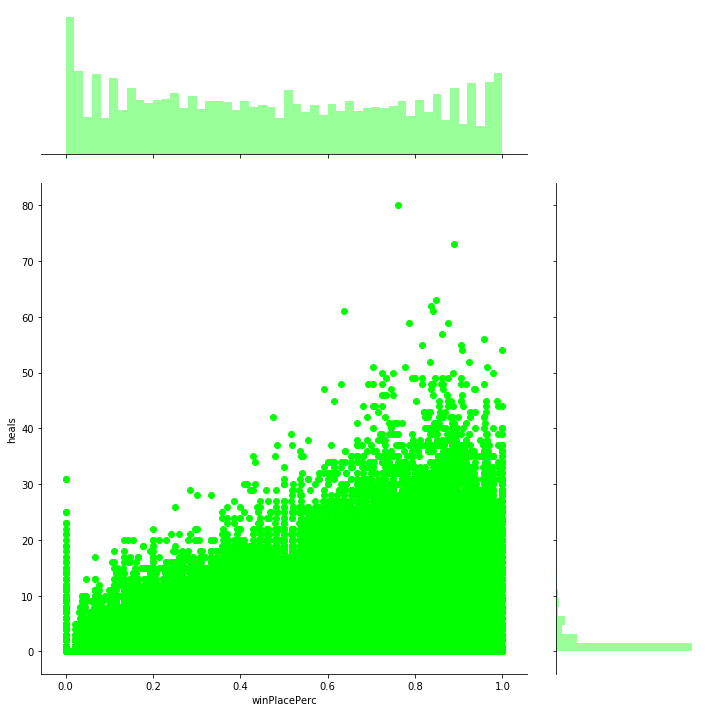

In [90]:
sns.jointplot(x = 'winPlacePerc', y = 'heals', data = train, height = 10, ratio = 3, color = 'lime')
plt.show()

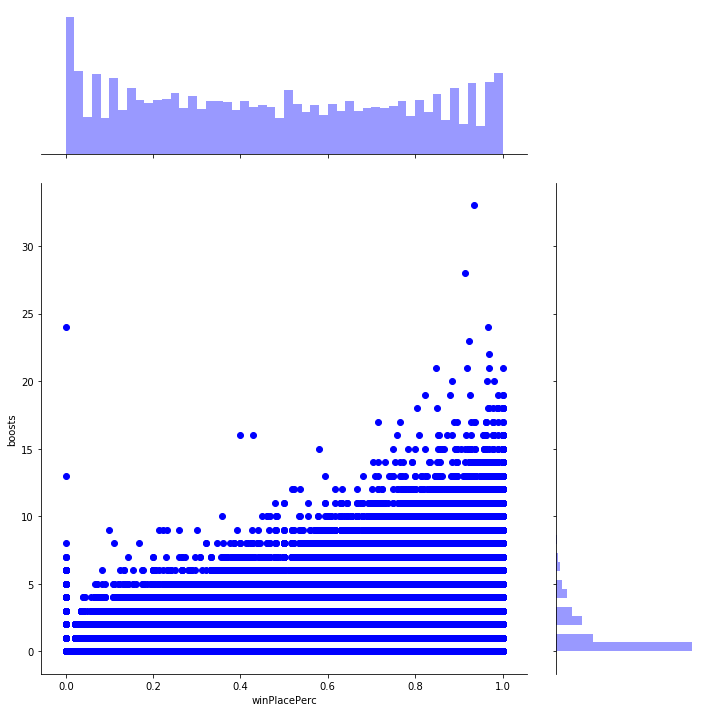

In [91]:
sns.jointplot(x = 'winPlacePerc', y = 'boosts', data = train, height = 10, ratio = 3, color = 'blue')
plt.show()

* # solo, Duo, Squad
- solo 는 솔플 혼자 한 팀을 이룸. 따라서 한 경기당 max 100teams
- duo 는 둘이서 한 팀을 이룸. max 50 teams
- squad는 셋 또는 넷이 한 팀. max 25 teams

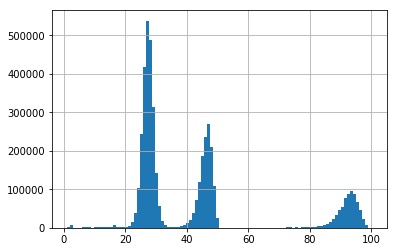

In [97]:
train.numGroups.hist(bins = 100)

In [98]:
#정확히 이렇다고 말 할 수 는 없지만, 대체로 그럴 것
solo = train[train.numGroups > 50]
duo = train[(train.numGroups > 25) & (train.numGroups <=50)]
squad = train[train.numGroups <= 25]

In [99]:
print('{} ({:.2f}%) solo games, {} ({:.2f}%) duo games, {} ({:.2f}%) squad games,'.format(len(solo), 100*len(solo) / len(train),
                                                                                         len(duo), 100*len(duo) / len(train),
                                                                                         len(squad), 100*len(squad) / len(train)))

709111 (15.95%) solo games, 3295326 (74.10%) duo games, 442529 (9.95%) squad games,


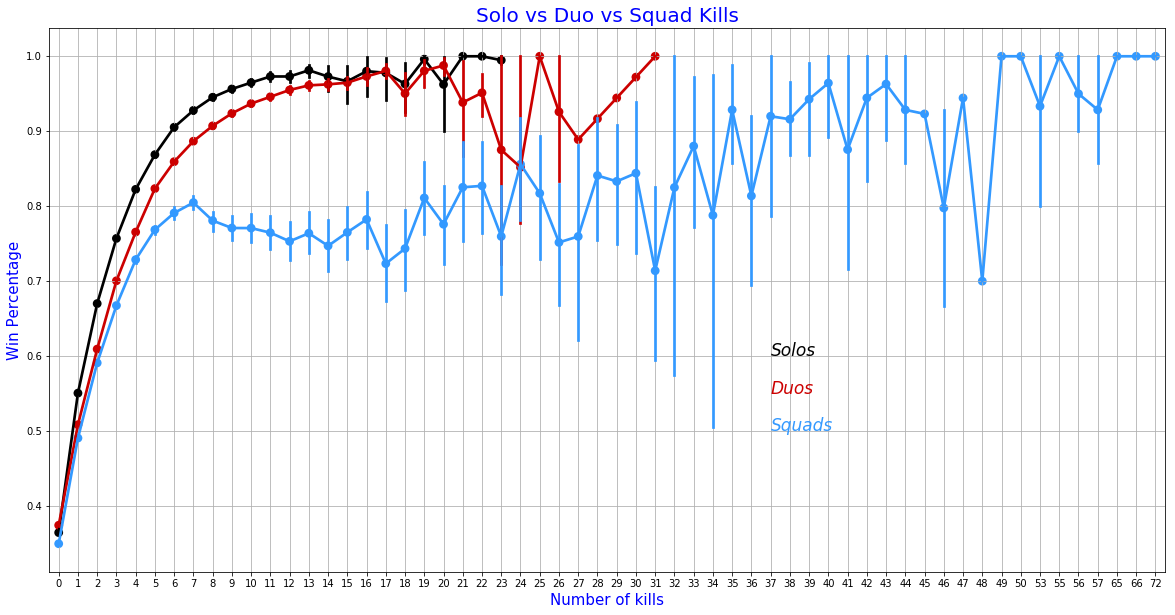

In [100]:
f, ax = plt.subplots(figsize = (20,10))

sns.pointplot(x = 'kills', y = 'winPlacePerc', data = solo, color = 'black', alpha = 0.8)
sns.pointplot(x = 'kills', y = 'winPlacePerc', data = duo, color = '#CC0000', alpha = 0.8)
sns.pointplot(x = 'kills', y = 'winPlacePerc', data = squad, color = '#3399FF', alpha = 0.8)

plt.text(37,0.6,'Solos',color='black',fontsize = 17,style = 'italic')
plt.text(37,0.55,'Duos',color='#CC0000',fontsize = 17,style = 'italic')
plt.text(37,0.5,'Squads',color='#3399FF',fontsize = 17,style = 'italic')
plt.xlabel('Number of kills',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Solo vs Duo vs Squad Kills',fontsize = 20,color='blue')
plt.grid()
plt.show()

- solo와 Duo는 비교적 비슷한 양상
- Squad는 아예 다른 양상. suad일 경우 kill수가 승률과 그렇게 큰 상관관계가 없어 보임


## DBNOs
- 적이 기절한 수이다. DBNO가 있다는 것은 듀오 혹은 스쿼드 경기라는 뜻.
## assists
- 우리 팀이 기절했을 때, 살려준 횟수. 이 역시 듀오 혹으 스쿼드 경기에서만 가능

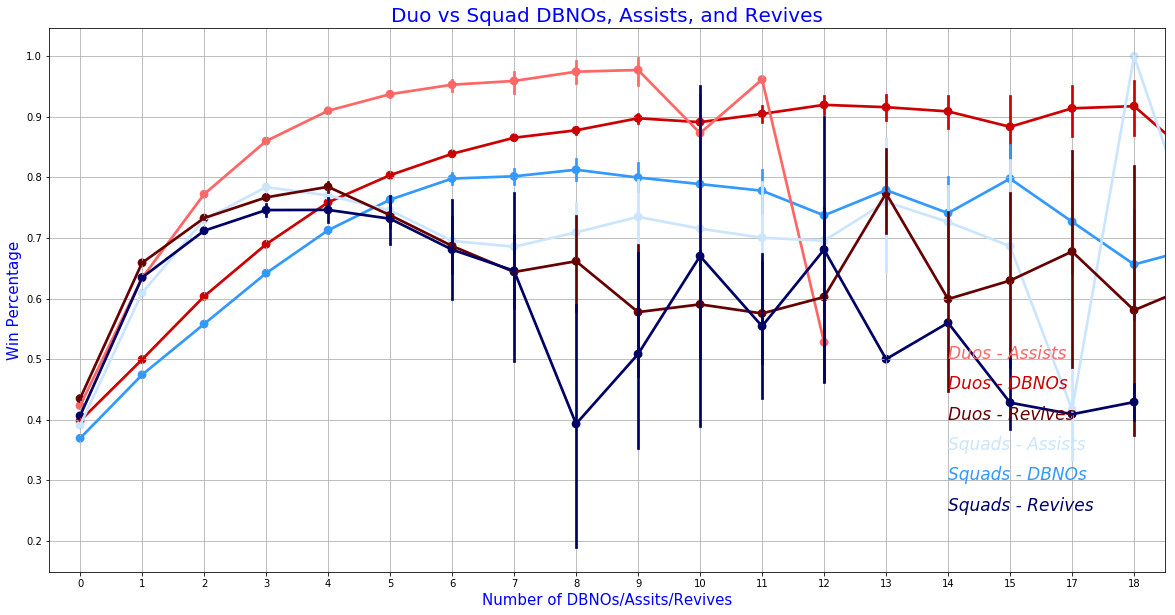

In [102]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='DBNOs',y='winPlacePerc',data=duo,color='#CC0000',alpha=0.8)
sns.pointplot(x='DBNOs',y='winPlacePerc',data=squad,color='#3399FF',alpha=0.8)
sns.pointplot(x='assists',y='winPlacePerc',data=duo,color='#FF6666',alpha=0.8)
sns.pointplot(x='assists',y='winPlacePerc',data=squad,color='#CCE5FF',alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc',data=duo,color='#660000',alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc',data=squad,color='#000066',alpha=0.8)
plt.text(14,0.5,'Duos - Assists',color='#FF6666',fontsize = 17,style = 'italic')
plt.text(14,0.45,'Duos - DBNOs',color='#CC0000',fontsize = 17,style = 'italic')
plt.text(14,0.4,'Duos - Revives',color='#660000',fontsize = 17,style = 'italic')
plt.text(14,0.35,'Squads - Assists',color='#CCE5FF',fontsize = 17,style = 'italic')
plt.text(14,0.3,'Squads - DBNOs',color='#3399FF',fontsize = 17,style = 'italic')
plt.text(14,0.25,'Squads - Revives',color='#000066',fontsize = 17,style = 'italic')
plt.xlabel('Number of DBNOs/Assits/Revives',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Duo vs Squad DBNOs, Assists, and Revives',fontsize = 20,color='blue')
plt.grid()
plt.show()

# Correlation

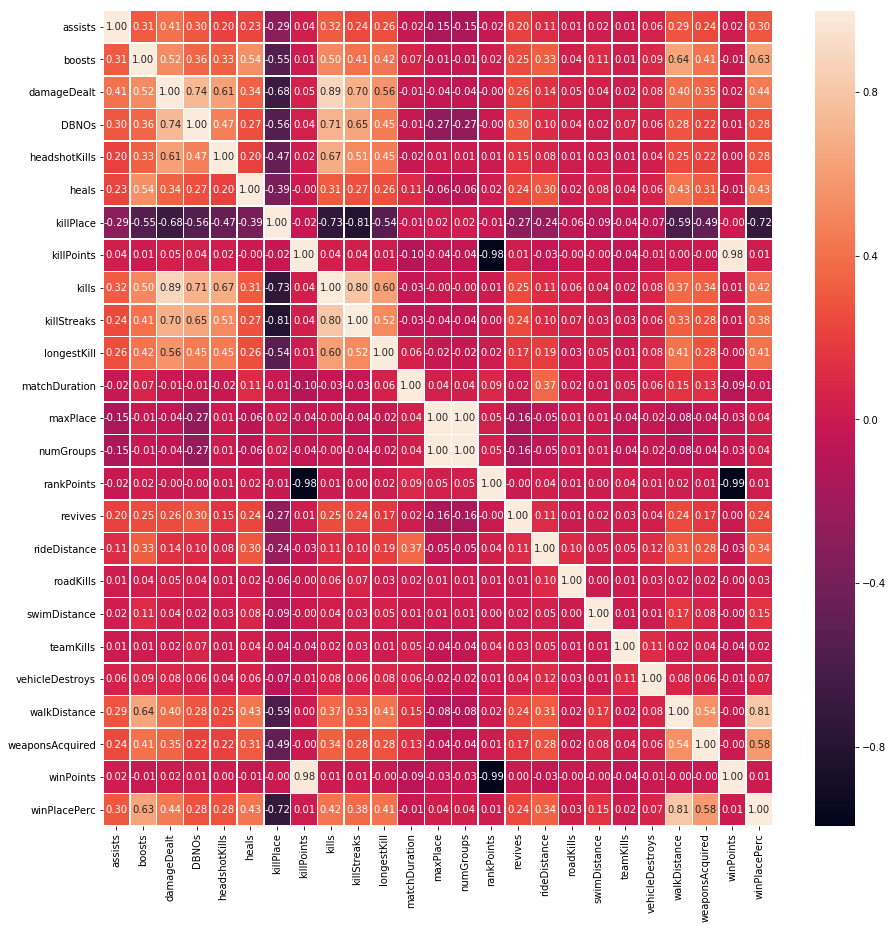

In [103]:
f, ax = plt.subplots(figsize = (15,15))
sns.heatmap(train.corr(), annot = True, linewidth = 0.5, fmt = '.2f', ax = ax)
plt.show()

## zoom it!

In [112]:
np.corrcoef(train[cols].values.T)

array([[       nan,        nan,        nan,        nan,        nan],
       [       nan, 1.        , 0.64015029, 0.54122168, 0.3981987 ],
       [       nan, 0.64015029, 1.        , 0.40660903, 0.52194748],
       [       nan, 0.54122168, 0.40660903, 1.        , 0.35324854],
       [       nan, 0.3981987 , 0.52194748, 0.35324854, 1.        ]])

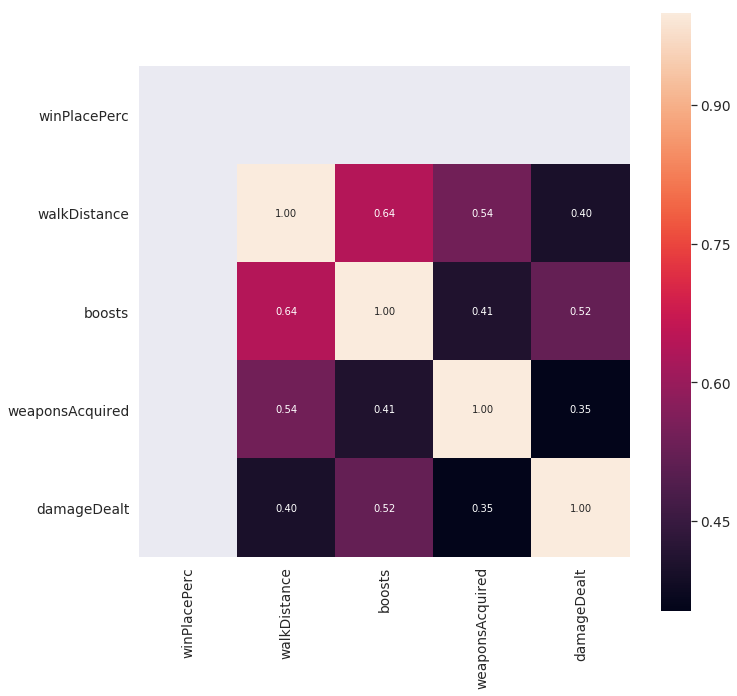

In [109]:
k = 5 #number of variables for heatmap

f,ax = plt.subplots(figsize=(11, 11))
cols = train.corr().nlargest(k, 'winPlacePerc')['winPlacePerc'].index #winPlacePerc를 기준으로 정렬하여 가장 큰 k개를 갖고 온 후 index 추출(자기 자신 포함)
cm = np.corrcoef(train[cols].values.T) #변수간 correlation 출력. k개의 변수를 입력하면 k*k개의 차원의 array 리턴

sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [113]:
sns.set()
cols = ['winPlacePerc', 'walkDistance', 'boosts', 'weaponsAcquired', 'damageDealt', 'killPlace']

sns.pairplot(train[cols], size = 2.5)
plt.show()

KeyboardInterrupt: 

# feature engineering
- playersJoined : 한 게임마다 참가하는 인원 수

In [121]:
train[train.matchId == 'a10357fd1a4a91'].shape

(96, 29)

In [122]:
#transofrm으로 함으로써 같은 matchId를 갖는 row의 개수로! 즉, 한 match에 들어가는 플레이어 수
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')

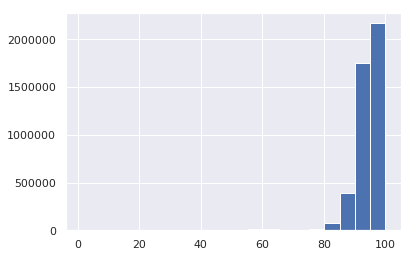

In [123]:
train['playersJoined'].hist(bins = 20)

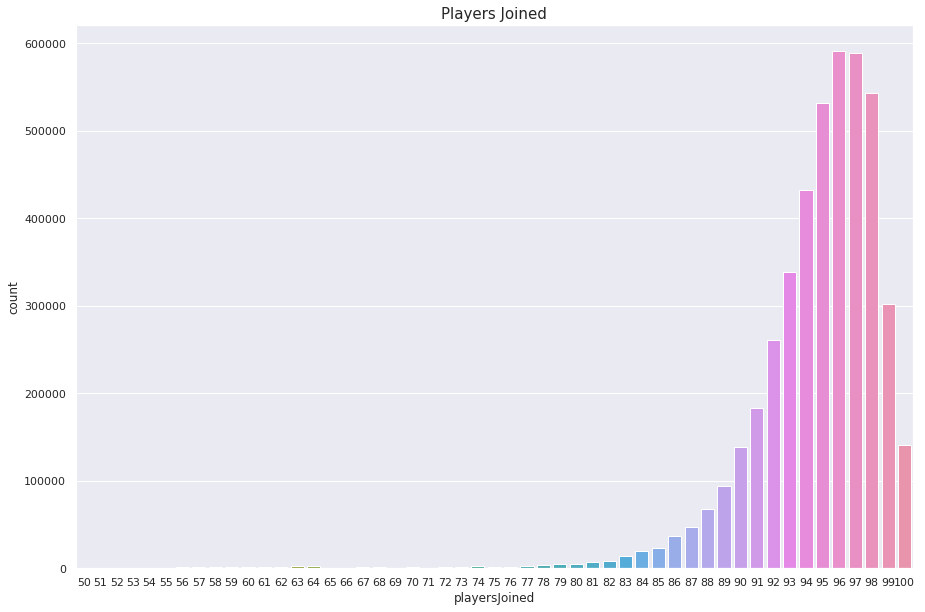

In [124]:
data = train.copy()
data = data[data.playersJoined > 49]

plt.figure(figsize = (15,10))
sns.countplot(data['playersJoined'])
plt.title('Players Joined', fontsize = 15)
plt.show()

playersJoined 변수를 이용하여 다른 변수들을 normalization

In [126]:
train['killsNorm'] = train['kills'] * ((100-train['playersJoined'])/100+1)
train['damageDealtNorm'] = train['damageDealt'] * ((100-train['playersJoined'])/100+1)

In [127]:
train[['playersJoined','kills','killsNorm','damageDealt','damageDealtNorm']].head()

,playersJoined,kills,killsNorm,damageDealt,damageDealtNorm
0,96,0,0.00,0.00,0.0000
1,91,0,0.00,91.47,99.7023
2,98,0,0.00,68.00,69.3600
3,91,0,0.00,32.90,35.8610
4,97,1,1.03,100.00,103.0000


In [128]:
train['healsANDboosts'] = train['heals'] + train['boosts']
train['totalDistance']  = train['walkDistance']+train['rideDistance']+train['swimDistance']

In [130]:
train['boostsPerWalkDistance'] = train['boosts']/(train['walkDistance']+1) #The +1 is to avoid infinity, because there are entries where boosts>0 and walkDistance=0. Strange.
train['boostsPerWalkDistance'].fillna(0, inplace=True)
train['healsPerWalkDistance'] = train['heals']/(train['walkDistance']+1) #The +1 is to avoid infinity, because there are entries where heals>0 and walkDistance=0. Strange.
train['healsPerWalkDistance'].fillna(0, inplace=True)
train['healsAndBoostsPerWalkDistance'] = train['healsANDboosts']/(train['walkDistance']+1) #The +1 is to avoid infinity.
train['healsAndBoostsPerWalkDistance'].fillna(0, inplace=True)

In [131]:
train['killsPerWalkDistance'] = train['kills']/(train['walkDistance']+1) #The +1 is to avoid infinity, because there are entries where kills>0 and walkDistance=0. Strange.
train['killsPerWalkDistance'].fillna(0, inplace=True)
train[['kills', 'walkDistance', 'rideDistance', 'killsPerWalkDistance', 'winPlacePerc']].sort_values(by='killsPerWalkDistance').tail(10)

,kills,walkDistance,rideDistance,killsPerWalkDistance,winPlacePerc
4115816,29,0.0,0.0,29.0,0.7500
3083358,30,0.0,0.0,30.0,0.7500
422093,30,0.0,0.0,30.0,1.0000
2394021,31,0.0,0.0,31.0,0.5385
3057746,31,0.0,0.0,31.0,0.7500
2998470,35,0.0,0.0,35.0,1.0000
1158891,36,0.0,0.0,36.0,0.5833
3062788,36,0.0,0.0,36.0,0.8667
1068513,38,0.0,0.0,38.0,0.8333
1702541,43,0.0,0.0,43.0,1.0000


In [132]:
train['team'] = [1 if i > 50 else 2 if (i>25 & i<=50) else 4 for i in train['numGroups']]

In [133]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,healsANDboosts,totalDistance,boostsPerWalkDistance,healsPerWalkDistance,healsAndBoostsPerWalkDistance,killsPerWalkDistance,team
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444,96,0.00,0.0000,0,244.8000,0.0,0.0,0.0,0.000000,2
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400,91,0.00,99.7023,0,1445.0445,0.0,0.0,0.0,0.000000,4
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755,98,0.00,69.3600,0,161.8000,0.0,0.0,0.0,0.000000,2
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667,91,0.00,35.8610,0,202.7000,0.0,0.0,0.0,0.000000,2
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875,97,1.03,103.0000,0,49.7500,0.0,0.0,0.0,0.019704,1
